In [1]:
### Imports
import gzip
from collections import defaultdict
import math
import numpy as np
import string
import random
import string
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import pandas as pd
import os
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
### EVALUATION / METRICS
######################################
def convert_to_np_array(A):
    """
    If A is not already an array, convert it to an array
    """
    if not isinstance(A, np.ndarray): return np.array(A)
    else: return A

def get_MSE(A, B):
    """
    Given list A and list B:
    Return the mean squared error between A and B
    """
    return np.mean((convert_to_np_array(A) - convert_to_np_array(B))**2)

def inner(A, B):
    """
    Return the dot product between list A and list B
    """
    return np.dot(convert_to_np_array(A), convert_to_np_array(B))

def get_SSE(A, B):
    """
    Given list A and list B:
    Return the sum of squared errors between A and B
    """
    return np.sum((convert_to_np_array(A) - convert_to_np_array(B))**2)

def get_MAE(A,B):
    """
    Given list A and list B:
    Return the mean absolute error between A and B
    """

    errors = [abs(a - b) for a,b in zip(A,B)]
    if len(errors) == 0: return 0
    return sum(errors) / len(errors)

def get_SE(A,B):
    """
    Given list A and list B:
    Return the squared error between each element
    """
    return (convert_to_np_array(A) - convert_to_np_array(B))**2

def get_accuracy(A,B):
    """
    Given list A and list B:
    Return the accuracy
    """
    return np.sum(convert_to_np_array(A) == convert_to_np_array(B)) / len(A)

def get_BER(y_actual, y_predicted):
    """
    "Return the balanced error rate between positive (1) and negative(0) instances
    """

    TP, FP, TN, FN = 0, 0, 0, 0
    n_pos, n_neg = 0, 0
    for actual, pred in zip(y_actual, y_predicted):
        if actual==1:
            n_pos += 1
            if actual==pred:
                TP += 1
            else:
                FN += 1
        else:
            n_neg += 1
            if actual==pred:
                TN += 1
            else:
                FP += 1
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)
        
    return (1/2) * (FPR + FNR)

def get_errorMetrics_binary(y_actual, y_predicted, beta=1):
    """
    Return a set of error metrics between positive (1) and negative (0) instances
    This is valid for a binary class case
    Return a dictionary containing all calculated values
    """

    output = {}
    TP, FP, TN, FN = 0, 0, 0, 0
    n_pos, n_neg = 0, 0
    for actual, pred in zip(y_actual, y_predicted):
        if actual==1:
            n_pos += 1
            if actual==pred:
                TP += 1
            else:
                FN += 1
        else:
            n_neg += 1
            if actual==pred:
                TN += 1
            else:
                FP += 1
    ###
    TPR, FNR = TP / n_pos, FN / n_pos
    FPR, TNR = FP / n_neg, TN / n_neg
    prec = TP / (TP + FP)
    recall = TP / (TP + FN)
    output["TP"], output["FP"], output["TN"], output["FN"] = TP, FP, TN, FN
    output["TPR"], output["FPR"], output["FNR"], output["TNR"] = TPR, FPR, FNR, TNR
    output["precision"], output["recall"] = prec, recall
    output["BER"] = (1/2) * (FPR + FNR)
    output[f"F{beta}_Score"] = (1 + beta**2) * (prec * recall) / ((beta**2)*prec + recall)
    output["F_Score"] = 2 * (prec * recall) / (prec + recall)

    return output

In [3]:
### SIMILARITY FUNCTIONS
######################################
def jaccard_sim(A,B):
    """
    Return the Jaccard similarity between list A and list B
    """
    if not isinstance(A, set): A = set(A)
    if not isinstance(B, set): B = set(B)
    n_intersect = len(A.intersection(B))
    n_union = len(A.union(B))
    if n_union == 0: return 0

    return n_intersect / n_union

def cosine_sim_binary(A,B, denom_over_all=True):
    """
    Return the cosine similarity between set A and set B (Binary interactions)
    """
    if not isinstance(A, set): A = set(A)
    if not isinstance(B, set): B = set(B)
    n_intersect = len(A.intersection(B))

    if denom_over_all:
        total_interactions = np.sqrt(len(A) * len(B))
    else:
        total_interactions = n_intersect
    if total_interactions == 0:
        return 0
    return n_intersect / total_interactions

############# Design structures to record shared items
def cosine_sim(x_tuple, y_tuple, denom_over_all):
    """
    Calculate the cosine similarity between lists x and y
    Input are lists of tuples: [(id1, rating), (id2, rating), ...]
    """
    # Get shared items
    x_ids, y_ids = set(), set()
    x_ratings, y_ratings = [], []
    shared_ratings_x, shared_ratings_y = [], []
    shared_tuples_x, shared_tuples_y = [], []
    for tuple in x_tuple:
        x_ids.add(tuple[0])
        x_ratings.append(tuple[1])
    for tuple in y_tuple:
        y_ids.add(tuple[0])
        y_ratings.append(tuple[1])
    shared_ids = x_ids.intersection(y_ids)

    shared_tuples_x = [tuple for tuple in x_tuple if tuple[0] in shared_ids]
    shared_tuples_x.sort()
    shared_tuples_y = [tuple for tuple in y_tuple if tuple[0] in shared_ids]
    shared_tuples_y.sort()
    shared_ratings_x = [tuple[1] for tuple in shared_tuples_x]
    shared_ratings_y = [tuple[1] for tuple in shared_tuples_y]

    if denom_over_all:
        # Use all items in the denominator
        x_norm = np.sum([xi**2 for xi in x_ratings])
        y_norm = np.sum([yi**2 for yi in y_ratings])
    else:
        # Only use shared items in the denominator
        x_norm = np.sum([xi**2 for xi in shared_ratings_x])
        y_norm = np.sum([yi**2 for yi in shared_ratings_y])
    denom = np.sqrt(x_norm) * np.sqrt(y_norm)

    if denom == 0: return 0
    numer = sum([xi*yi for xi,yi in zip(shared_ratings_x, shared_ratings_y)])

    return numer / denom

def pearson_sim(x_tuple, y_tuple):
    """
    Calculate the pearson similarity between lists x and y
    Input are lists of tuples: [(id1, rating), (id2, rating), ...]
    Unlike Cosine sim, ONLY shared items can be considered
    If id1 or id2 is not in the relevant training data structure, use meanValue as its respective mean
    """
    # Unpack averages
    x_avgs = {tuple[0][0]:tuple[1] for tuple in x_tuple}
    y_avgs = {tuple[0][0]:tuple[1] for tuple in y_tuple}
    # Get shared items
    shared_ratings_x, shared_ratings_y = [], []
    shared_tuples_x, shared_tuples_y = [], []
    x_ids = {tuple[0][0] for tuple in x_tuple}
    y_ids = {tuple[0][0] for tuple in y_tuple}
    shared_ids = x_ids.intersection(y_ids)

    shared_tuples_x = [tuple[0] for tuple in x_tuple if tuple[0][0] in shared_ids]
    shared_tuples_x.sort()
    shared_tuples_y = [tuple[0] for tuple in y_tuple if tuple[0][0] in shared_ids]
    shared_tuples_y.sort()
    shared_ratings_x = [tuple[1] - x_avgs[tuple[0]] for tuple in shared_tuples_x] ### Pearson --> Subtract the mean from each value
    shared_ratings_y = [tuple[1] - y_avgs[tuple[0]] for tuple in shared_tuples_y]

    # Only use shared items in the denominator
    x_norm = np.sum([xi**2 for xi in shared_ratings_x])
    y_norm = np.sum([yi**2 for yi in shared_ratings_y])
    denom = np.sqrt(x_norm * y_norm)

    if denom == 0: return 0
    numer = sum([xi*yi for xi,yi in zip(shared_ratings_x, shared_ratings_y)])

    return numer / denom


In [4]:
### COLLABORATIVE FILTERING
######################################


def predictValue_bySim_devFromMean(user_id, item_id, sim_func, type, meanValue, value_bounds=None, denom_over_all=None, **kwargs):
    """
    Predict some value (e.g., rating) that the user (user_id) will give an item (item_id) based on
    the input simularity function (sim_func). However, instead of predicting the rating directly,
    predict the deviation from the global mean rating

    # Necessary Data Structures --> These are built using training data ONLY
    itemsPerUser: A dictionary containing the list of items each user interacted with and corresponding values
       ex: itemsPerUser[user1] = [(item1, 2), (item3, 1), (item5, 5), ...]
    usersPerItem: A dictionary containing the list of users that interacted with each item and corresponding values
       ex: usersPerItem[item1] = [(user1, 2), (user4, 2), (user27, 2), ...]
    itemAverages: A dictionary containing the mean value for each item
    userAverages: A dictionary containing the mean value for each user
    #--- value_bounds: The min/max values that can be outputted as typically there's a scale (e.g., 1-5 stars)
    #--- meanValue: The mean of all values in valueDict.values()

    # Gathering similarity weights:
    If type==0:
       # Predict the rating as a weighted sum of ratings that user_id has given to other items #
       For each item (item_id2) that user_id has interacted with (except for item_id):
          Calculate item_id2's similarity to item_id based on shared user interactions
          Track these values as similarity weights
    else:
       # Predict the rating as a weighted sum of ratings that other users have given to item_id #
       For each user (user_id2) that have interacted with item_id (except for user_id):
          Calculate user_id2's similarity to user_id based on shared item interactions
          Track these values as similarity weights
    """
    # Edge case 1: Return global mean value if user_id or item_id are unseen
    if (user_id not in itemsPerUser) or (item_id not in usersPerItem): return meanValue
    # Initialize variables
    if denom_over_all is None: denom_over_all = True
    if value_bounds is None: value_bounds = (-np.inf, np.inf)
    values, similarities = [], []

    if type == "item":
        # Predict the rating as a weighted combination of how other items rated by user_id were
        # rated by similar users
        # if user_id not in userAverages: return meanValue # Skip keys that are not in the dict
        avg_value = userAverages[user_id]
        for user_id2,value in usersPerItem[item_id]:
            if user_id2 == user_id: continue
            # if user_id2 not in userAverages: continue  # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple[0] for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple[0] for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_user_id = {tuple for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {tuple for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_user_id = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id] if tuple[0] != item_id}
                simset_user_id2 = {(tuple, itemAverages[tuple[0]]) for tuple in itemsPerUser[user_id2] if tuple[0] != item_id}
                similarities.append(sim_func(simset_user_id, simset_user_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value - userAverages[user_id2])
    else:
        # Predict user_id's rating of item_id based on a weighted combination of how other users who
        # rated item_id rated other items
        # if item_id not in itemAverages: return meanValue # Skip keys that are not in the dict
        avg_value = itemAverages[item_id]
        for item_id2,value in itemsPerUser[user_id]:
            if item_id2 == item_id: continue
            # if item_id2 not in itemAverages: continue # Skip keys that are not in the dict
            if sim_func == jaccard_sim:
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            elif sim_func == cosine_sim_binary:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple[0] for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple[0] for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == cosine_sim:
                if denom_over_all is None: denom_over_all = True
                simset_item_id = {tuple for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {tuple for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2, denom_over_all))
            elif sim_func == pearson_sim:
                simset_item_id = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id] if tuple[0] != user_id}
                simset_item_id2 = {(tuple, userAverages[tuple[0]]) for tuple in usersPerItem[item_id2] if tuple[0] != user_id}
                similarities.append(sim_func(simset_item_id, simset_item_id2))
            else:
                # Sim function not programmed
                print("Invalid sim_func")
                return None
            values.append(value - itemAverages[item_id2])
    # Edge case 2: Return global mean value if there are no similar items
    if np.sum(similarities) == 0: return meanValue

    numerator = np.sum([value*sim for value,sim in zip(values, similarities)])
    denominator = np.sum(similarities)
    output = avg_value + (numerator / denominator)
    if output < value_bounds[0]: return value_bounds[0]
    if output > value_bounds[1]: return value_bounds[1]

    return output

In [5]:
### LATENT FACTOR MODEL
######################################
def initialize_params(ratingDict, itemsPerUser, usersPerItem, k, init_bounds):
    """
    Return the initialized parameters
    """
    user_count, item_count = len(itemsPerUser), len(usersPerItem)
    lower, upper = init_bounds
    alpha = np.mean([i for i in ratingDict.values()])
    user_bias = dict(zip(users, [random.uniform(lower,upper) for i in range(user_count)]))
    item_bias = dict(zip(items, [random.uniform(lower,upper) for i in range(item_count)]))
    user_gamma = dict(zip(users, [[random.uniform(lower,upper) for ki in range(k)] for i in range(user_count)]))
    item_gamma = dict(zip(items, [[random.uniform(lower,upper) for ki in range(k)] for i in range(item_count)]))

    return (alpha, user_bias, item_bias, user_gamma, item_gamma)

def get_lfm_defaults(theta):
    """
    Calculate average values/vectors to use as default values for the latent factor predictions
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    avg_params = {}
    avg_params["avg_user_bias"] = np.mean(np.array([i for i in user_bias.values()]))
    avg_params["avg_item_bias"] = np.mean(np.array([i for i in item_bias.values()]))
    avg_params["avg_user_gamma"] = np.mean(np.array([values for values in user_gamma.values()]), axis=0)
    avg_params["avg_item_gamma"] = np.mean(np.array([values for values in item_gamma.values()]), axis=0)

    return avg_params

def predict_latent_factor(u_id, item_id, theta, value_bounds = None, avg_params = None):
    """
    Return the prediction based on u_id and item_id
    If u_id is not in itemsPerUser --> Use the average gamma vector
    Repeat this process for if item_id is not in usersPerItem

    Bound the output by the min and max of the possible values 
    (ex: Model shouldn't exceed 5 when the scale is 5)
    """
    if value_bounds is None: value_bounds = (-np.inf, np.inf)
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    for i,(gamma_vec) in enumerate(user_gamma.values()):
        if i > 0: break
        k = len(gamma_vec)

    if u_id in user_bias: u_bias = user_bias[u_id]
    else:
        if (avg_params is not None) and (item_id in item_bias): u_bias = avg_params["avg_user_bias"]
        else: u_bias = 0

    if item_id in item_bias: i_bias = item_bias[item_id]
    else:
        if (avg_params is not None) and (u_id in user_bias): i_bias = avg_params["avg_item_bias"]
        else: i_bias = 0

    if u_id in user_gamma: u_gamma = np.array(user_gamma[u_id])
    else:
        if (avg_params is not None) and (item_id in item_gamma): u_gamma = avg_params["avg_user_gamma"]
        else: u_gamma = [0]*k

    if item_id in item_gamma: i_gamma = np.array(item_gamma[item_id])
    else:
        if (avg_params is not None) and (u_id in user_gamma): i_gamma = avg_params["avg_item_gamma"]
        else: i_gamma = [0]*k

    value = alpha + u_bias + i_bias + np.dot(u_gamma, i_gamma)
    if value < value_bounds[0]: return value_bounds[0]
    if value > value_bounds[1]: return value_bounds[1]

    return value

def get_cost(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, k, value_bounds=None):
    """
    Calculate the cost for the given theta parameters
    Xtrain must be of form [(user, item), (user, item), ...]
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    # Predict using the current theta values
    predictions = np.array([predict_latent_factor(tuple[0], tuple[1], theta, value_bounds) for tuple in Xtrain])
    # Calculate SSE + regularization
    cost = get_SSE(predictions, ytrain)
    cost += lambda_bias * np.sum(np.array([val**2 for val in user_bias.values()]))
    cost += lambda_bias * np.sum(np.array([val**2 for val in item_bias.values()]))
    cost += lambda_gamma * np.sum(np.array([inner(gam, gam) for gam in user_gamma.values()]))
    cost += lambda_gamma * np.sum(np.array([inner(gam, gam) for gam in item_gamma.values()]))

    return cost

def update_params(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, fix_value):
    """
    Update parameters based on how well they predict in their CURRENT states
    Coordinate descent instead of gradient descent for faster convergence
    ###
    Latent factor model
         Fix user_gamma --> iterate and update alpha, user_bias, item_gamma
         Fix item_gamma --> iterate and update alpha, user_bias, user_gamma
    Fix user_gamma... Fix item_gamma...
    Repeat the above until model have converged
    """
    alpha, user_bias, item_bias, user_gamma, item_gamma = theta
    # Iterate through the alpha and bias params
    if (fix_value == 0) or (fix_value == 4):
        # Calculate the new alpha
        alpha_sum = 0
        for tuple, rating in zip(Xtrain, ytrain):
            u_id, item_id = tuple
            alpha_sum += (rating - (user_bias[u_id] + item_bias[item_id] + inner(user_gamma[u_id], item_gamma[item_id])))
        dalpha = alpha_sum / N
        alpha = dalpha.copy()
    elif (fix_value == 1) or (fix_value == 5):
        # Calculate the new user bias
        duser_bias = {}
        for u_id in users:
            user_sum = 0
            users_item_count = len(itemsPerUser[u_id])
            for tuple in itemsPerUser[u_id]:
                item_id, rating = tuple
                user_sum += (rating - (alpha + item_bias[item_id] + inner(user_gamma[u_id], item_gamma[item_id])))
            duser_bias[u_id] = (user_sum * (1 / (users_item_count + lambda_bias)))
        user_bias = duser_bias.copy()
    elif (fix_value == 2) or (fix_value == 6):
        # Calculate the new item bias
        ditem_bias = {}
        for item_id in items:
            item_sum = 0
            items_user_count = len(usersPerItem[item_id])
            for tuple in usersPerItem[item_id]:
                u_id, rating = tuple
                item_sum += (rating - (alpha + user_bias[u_id] + inner(user_gamma[u_id], item_gamma[item_id])))
            ditem_bias[item_id] = (item_sum * (1 / (items_user_count + lambda_bias)))
        item_bias = ditem_bias.copy()
    elif fix_value == 3:
        # Calculate the new user gamma
        duser_gamma = {}
        for u_id in users:
            user_sums = [0] * k
            i_gamma_k_sqrd_sums = [0] * k
            users_item_count = len(itemsPerUser[u_id])
            for tuple in itemsPerUser[u_id]:
                item_id, rating = tuple
                # Update each user's gamma value
                for ki in range(k):
                    i_gamma_k = item_gamma[item_id][ki]
                    i_gamma_k_sqrd_sums[ki] += i_gamma_k**2
                    user_sums[ki] = i_gamma_k * (rating - (alpha + user_bias[u_id] + item_bias[item_id]))
            duser_gamma[u_id] = [user_sums[ki] * (1 / (users_item_count*i_gamma_k_sqrd_sums[ki] + lambda_gamma)) for ki in range(k)]
        user_gamma = duser_gamma.copy()
    elif fix_value == 7:
         # Calculate the new item gamma
        ditem_gamma = {}
        for item_id in items:
            item_sums = [0] * k
            u_gamma_k_sqrd_sums = [0] * k
            items_user_count = len(usersPerItem[item_id])
            for tuple in usersPerItem[item_id]:
                u_id, rating = tuple
                # Update each item's gamma value
                for ki in range(k):
                    u_gamma_k = user_gamma[u_id][ki]
                    u_gamma_k_sqrd_sums[ki] += u_gamma_k**2
                    item_sums[ki] = u_gamma_k * (rating - (alpha + user_bias[u_id] + item_bias[item_id]))
            ditem_gamma[item_id] = [item_sums[ki] * (1 / (items_user_count*u_gamma_k_sqrd_sums[ki] + lambda_gamma)) for ki in range(k)]
        item_gamma = ditem_gamma.copy()

    return (alpha, user_bias, item_bias, user_gamma, item_gamma)

def fit_parameters(Xtrain, ytrain, theta, ep=0.0005, iter_limit=200, quiet=True, value_bounds=(-np.inf, np.inf), check_every=10, **kwargs):
    """
    Fit the parameters until convergence (when difference in cost is less than ep)
    Arguments packed into **kwargs:
    lambda_bias --> Regularization parameter for the user/item biases
    lambda_gamma --> Regularization parameter for the user/item gamma matrix
    k --> Number of latent parameters to use per user/item vector
    ep --> The threshold for early stopping between mse checks
    iter_limit --> The maximum number of iterations allowed
    value_bounds --> The expected range of values expected to be outputted by the model
    check_every --> Calculate the cost/mse whenever iter_count is perfectly divisible by check_every (ex: check_every=10 means check every 10 iterations)
    """
    last_mse, last_cost = np.inf, np.inf
    best_params = [theta, last_mse, last_cost]

    iter_count = 0
    while True:
        # Track iteration count as well as which parameter to update (fix_value)
        iter_count += 1
        fix_value = (iter_count - 1) % 8

        # Update theta
        theta = update_params(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, fix_value)

        # Every few iterations, check cost and mse
        if (iter_count % check_every == 0):
            cost = get_cost(theta, lambda_bias, lambda_gamma, Xtrain, ytrain, k, value_bounds)
            predictions = np.array([predict_latent_factor(tuple[0], tuple[1], theta, value_bounds) for tuple in Xtrain])
            mse = get_MSE(predictions, ytrain)
            if not quiet:
                print(f"Iteration {iter_count}: Cost = {cost}, Train MSE = {mse}")
            ### Check cost/mse
            # Save current params as best_params if the mse is less than the last mse
            if mse < best_params[1]:
                best_params = [theta, mse, cost]
                # If the difference in cost is less than ep, stop iterating
                if last_mse - mse > ep:
                    last_mse = mse
                    last_cost = cost
                else:
                    if not quiet:
                        print(f"Convergence after {iter_count} iterations: Cost = {cost}, Train MSE = {mse}")
                    break
            # Check if cost is too high - sometimes the algorithm diverges
            if mse > 5000:
                theta, mse, cost = best_params
                if not quiet:
                    print(f"Training MSE too high: Best Train MSE = {best_params[1]}")
                break
        # If the iteration limit is reached, stop and return the best parameters
        if iter_count > iter_limit:
            theta, mse, cost = best_params
            if not quiet:
                print(f"Iteration limit reached after {iter_count} iterations: Best Train MSE = {best_params[1]}")
            break

    return (theta, cost, mse)


In [6]:
### Popularity-based Baseline
#
# Rank the items in the dataset based on popularity --> If the item is popular, predict 1, else 0

def get_item_popularities(df, col):
    # Define popularity: The items which have the highest playtime per person ratios weighted by number of plays
    item_playCounts = df.groupby("item_id").agg("sum")[col]
    item_playCountsBinary = df.groupby("item_id").agg("sum")["playtime_binary"]
    item_userCounts = df.groupby("item_id").count()["user_id"]

    item_playsPerUser = (item_playCountsBinary / item_userCounts).sort_values(ascending=True)
    # item_playsPerUser = (item_playCounts).sort_values(ascending=True)

    return pd.DataFrame({"pop_values":item_playsPerUser, "pop_sums":item_playsPerUser.cumsum()})

def get_most_popular_items(df, cutoff):
    pop_cutoff = df["pop_values"].max() * cutoff

    return list(df[df["pop_values"] > pop_cutoff].index)

def predict_by_popularity(X, pop_items):
    if isinstance(X, tuple):
        if X[1] in pop_items: return 1
        else: return 0
    else:
        output = pd.Series([0 for i in range(len(X))])
        output[X["item_id"].isin(pop_items)] = 1
        return output

#####

In [7]:
### OTHER HELPFUL FUNCTIONS
######################################
def get_rec_structs(train_data):
    """
    Extract stats used for creating the classifier features
    Input is (user_id, item_id, value), ...
    Typically value is rating, but can be other things (e.g., hours played)

    itemsPerUser: Records each item in the training set that each user interacted with (along with the corresponding value)
    usersPerItem: Records each user in the training set that each item interacted with (along with the corresponding value)
    valueDict: Records the value for each (user, item) tuple
    userAverages: Gives the average value for each user
    itemAverages: Gives the average value for each item
    """
    ### Record which items each user interacted with and which users interacted with which item
    itemsPerUser = defaultdict(list)
    usersPerItem = defaultdict(list)
    valueDict = {}
    for u,b,v in train_data:
        itemsPerUser[u].append((b,v))
        usersPerItem[b].append((u,v))
        valueDict[(u,b)] = v

    ### Calculate user and item average ratings
    userAverages = {}
    itemAverages = {}
    for u,tuples in itemsPerUser.items():
        values = [value for item,value in tuples]
        # values = [value for item,value in tuples if value != 0]
        # if len(values) == 0: continue
        userAverages[u] = sum(values) / len(values)
    for i,tuples in usersPerItem.items():
        values = [value for user,value in tuples]
        # values = [value for user,value in tuples if value != 0]
        # if len(values) == 0: continue
        itemAverages[i] = sum(values) / len(values)

    rec_structs = {"itemsPerUser":itemsPerUser,
                  "usersPerItem":usersPerItem,
                  "valueDict":valueDict,
                  "userAverages":userAverages,
                  "itemAverages":itemAverages,}

    return rec_structs

def unpack_rec_structs(rec_structs):
    """
    Take the input recommender_structs and return the itemized contents
    """
    itemsPerUser = rec_structs["itemsPerUser"]
    usersPerItem = rec_structs["usersPerItem"]
    valueDict = rec_structs["valueDict"]
    userAverages = rec_structs["userAverages"]
    itemAverages = rec_structs["itemAverages"]

    return (itemsPerUser, usersPerItem, valueDict, userAverages, itemAverages)

### Functions to read files (From homework stubs)
def readGz(path):
    output = []
    for l in gzip.open(path, mode = 'rt', encoding = "utf-8"):
        output.append(eval(l))
    return output

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [8]:
%%time
### Load the datasets
seed = 100

minmax_scalers = pd.read_csv("data/minmax_scalers.csv")
user_bins = pd.read_csv("data/user_bins.csv")
item_bins = pd.read_csv("data/item_bins.csv")

user_bins[["count_bin", "play_bin", "fracPlayed_bin"]].value_counts()

CPU times: total: 46.9 ms
Wall time: 43 ms


count_bin  play_bin  fracPlayed_bin
123.0      81.0      0.9               1183
25.0       17.0      0.9               1077
11.0       8.0       0.9                550
123.0      81.0      0.7                510
44.0       31.0      0.9                492
                                       ... 
5588.0     31.0      0.4                  1
           4.0       0.1                  1
33.0       4.0       0.1                  1
59.0       4.0       0.1                  1
44.0       81.0      1.0                  1
Name: count, Length: 124, dtype: int64

In [9]:
### Import datasets
data_dir = "data/"
marker = "test_results_"
extract_ind = len(marker)
test_data = {}
0
# ignore_files = ["baseline", "CF"]
ignore_files = []

for file in os.listdir(data_dir):
    if file.startswith(marker):
        key = file[extract_ind:-4]
        if key in ignore_files: continue
        test_data[key] = pd.read_csv(data_dir + file).set_index(["user_id", "item_id"], drop=True)

for key,dat in test_data.items():
    print(key)

baseline
CF
CF_upperBoundedPearson
FM_1genres_withOther_k3_lb1_lg3
FM_1tags_withOther_k3_lb1_lg3
FM_21genres_withOther_k5_lb1_lg5
FM_21tags_withOther_k5_lb1_lg7
FM_3genres_withOther_k3_lb1_lg5
FM_3tags_withOther_k3_lb1_lg5
FM_5genres_withOther_k5_lb1_lg3
FM_5tags_withOther_k5_lb1_lg3
LFM_k1_lb0.0_lg0.6666666666666666


In [10]:
pred_cols = []
other_cols = ["user_id", "item_id", "playtime", "playtime_log"]

### Accumulate columns
for model in test_data.values():
    pred_cols.extend(model.columns[~model.columns.isin(other_cols)])

print(pred_cols)

['baseline_mean_pred', 'baseline_median_pred', 'jaccard_sim_u_pred', 'jaccard_sim_i_pred', 'cosine_sim_binary_u_pred', 'cosine_sim_binary_i_pred', 'cosine_sim_u_pred', 'cosine_sim_i_pred', 'pearson_sim_u_pred', 'pearson_sim_i_pred', 'pearson_sim_u_pred_upperBounded', 'pearson_sim_i_pred_upperBounded', 'pred_1genres_withOther__k3_lb1_lg3', 'pred_1tags_withOther__k3_lb1_lg3', 'pred_21genres_withOther__k5_lb1_lg5', 'pred_21tags_withOther__k5_lb1_lg7', 'pred_3genres_withOther__k3_lb1_lg5', 'pred_3tags_withOther__k3_lb1_lg5', 'pred_5genres_withOther__k5_lb1_lg3', 'pred_5tags_withOther__k5_lb1_lg3', 'LFM_preds']


In [11]:
### Combine to a single dataframe
drop_cols = ["playtime"]
drop_cols2 = ["playtime_log"]
on_cols = ["user_id", "item_id"]

data = test_data["baseline"].copy().drop(columns=drop_cols)
for key,model in test_data.items():
    if key=="baseline": continue
    data = data.merge(model.drop(columns=drop_cols2), on=on_cols)

data

,,playtime_log,baseline_mean_pred,baseline_median_pred,jaccard_sim_u_pred,jaccard_sim_i_pred,cosine_sim_binary_u_pred,cosine_sim_binary_i_pred,cosine_sim_u_pred,cosine_sim_i_pred,pearson_sim_u_pred,...,pred_1genres_withOther__k3_lb1_lg3,pred_1tags_withOther__k3_lb1_lg3,pred_21genres_withOther__k5_lb1_lg5,pred_21tags_withOther__k5_lb1_lg7,pred_3genres_withOther__k3_lb1_lg5,pred_3tags_withOther__k3_lb1_lg5,pred_5genres_withOther__k5_lb1_lg3,pred_5tags_withOther__k5_lb1_lg3,playtime,LFM_preds
user_id,item_id,,,,,,,,,,,,,,,,,,,,,
u5084,31130,0.000000,3.30626,3.496508,0.000000,1.149872,0.000000,1.160911,0.000000,1.139369,0.093175,...,0.839389,0.613902,0.916284,0.678450,1.019262,0.662215,0.857864,1.009399,0,0.896817
u11861,233270,6.573680,3.30626,3.496508,4.002157,4.111752,4.009689,4.036022,4.058618,4.067302,9.543464,...,3.612861,3.909616,3.599461,3.871792,3.492579,3.866804,3.893818,3.520402,715,3.887373
u4949,220200,5.451038,3.30626,3.496508,6.592512,6.130139,6.582512,6.142174,6.660515,6.185463,7.440528,...,6.455335,6.373684,6.480559,6.415367,6.489593,6.356270,6.454592,6.532297,232,6.423125
u1808,4000,5.446737,3.30626,3.496508,7.785576,6.875094,7.784912,6.932624,8.012718,8.474173,0.000000,...,7.773258,7.678347,7.765848,7.688191,7.776652,7.638390,7.695547,7.749893,231,7.733643
u5401,1280,0.000000,3.30626,3.496508,1.225296,1.380342,1.227562,1.390992,1.397568,1.344395,118.158063,...,1.337303,1.341933,1.353000,1.370707,1.315398,1.329915,1.366580,1.338187,0,1.275084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u11442,238960,3.044522,3.30626,3.496508,3.678588,4.617372,3.682926,4.553322,3.996505,4.679888,3.169614,...,2.828913,2.915822,2.928427,2.893689,2.882622,2.961655,3.005277,2.817802,20,3.165356
u12710,4000,9.467847,3.30626,3.496508,7.757600,8.045949,7.756390,8.008331,7.500237,7.860650,8.513014,...,8.124847,7.972402,8.023653,8.060795,8.164117,7.970410,8.000626,8.091772,12936,8.055044
u10496,8190,5.337538,3.30626,3.496508,5.293708,4.876471,5.274781,4.892238,5.683755,4.893628,3.172978,...,4.915532,4.828012,4.857237,4.821053,4.860619,4.791677,4.842394,4.935458,207,4.865276


In [12]:
### Get MSEs and MAEs
mses, maes = {}, {}
for pred_col in pred_cols:
    if pred_col in data.columns:
        mses[pred_col] = get_MSE(data["playtime_log"], data[pred_col])
        maes[pred_col] = get_MAE(data["playtime_log"], data[pred_col])

for (key,mse) in mses.items():
    # print(f"Model: {key}\nMSE: {np.round(mse,5)}, MAE: {np.round(maes[key],35}\n")
    print(f"|{np.round(mse,5)}|{np.round(maes[key],5)}|{key}|||")

### Remove regular pearson from pred_cols
pred_cols.remove("pearson_sim_u_pred")
pred_cols.remove("pearson_sim_i_pred")
pred_cols.remove("pearson_sim_u_pred_upperBounded")
pred_cols.remove("pearson_sim_i_pred_upperBounded")

|9.18711|2.71691|baseline_mean_pred|||
|9.22322|2.71382|baseline_median_pred|||
|4.73795|1.68411|jaccard_sim_u_pred|||
|4.86753|1.71192|jaccard_sim_i_pred|||
|4.74513|1.68625|cosine_sim_binary_u_pred|||
|4.88625|1.71586|cosine_sim_binary_i_pred|||
|5.091|1.75482|cosine_sim_u_pred|||
|4.90997|1.71453|cosine_sim_i_pred|||
|6.1346027184097785e+29|8635645495796.828|pearson_sim_u_pred|||
|3.417452448662927e+28|1178071778627.5146|pearson_sim_i_pred|||
|17.83474|3.00121|pearson_sim_u_pred_upperBounded|||
|16.64488|2.88379|pearson_sim_i_pred_upperBounded|||
|4.26297|1.57562|pred_1genres_withOther__k3_lb1_lg3|||
|4.25516|1.57319|pred_1tags_withOther__k3_lb1_lg3|||
|4.25333|1.57381|pred_21genres_withOther__k5_lb1_lg5|||
|4.25323|1.57546|pred_21tags_withOther__k5_lb1_lg7|||
|4.25195|1.57565|pred_3genres_withOther__k3_lb1_lg5|||
|4.24724|1.5737|pred_3tags_withOther__k3_lb1_lg5|||
|4.25671|1.57289|pred_5genres_withOther__k5_lb1_lg3|||
|4.26678|1.57428|pred_5tags_withOther__k5_lb1_lg3|||
|4.25651|1.

In [13]:
mses

{'baseline_mean_pred': 9.187107397527571,
 'baseline_median_pred': 9.223215240818883,
 'jaccard_sim_u_pred': 4.737950044059364,
 'jaccard_sim_i_pred': 4.867528059652673,
 'cosine_sim_binary_u_pred': 4.7451277637920795,
 'cosine_sim_binary_i_pred': 4.886251050694774,
 'cosine_sim_u_pred': 5.090995728024267,
 'cosine_sim_i_pred': 4.909973274460683,
 'pearson_sim_u_pred': 6.1346027184097785e+29,
 'pearson_sim_i_pred': 3.4174524486629264e+28,
 'pearson_sim_u_pred_upperBounded': 17.83474172076065,
 'pearson_sim_i_pred_upperBounded': 16.644882354157737,
 'pred_1genres_withOther__k3_lb1_lg3': 4.262973046010233,
 'pred_1tags_withOther__k3_lb1_lg3': 4.25515550326865,
 'pred_21genres_withOther__k5_lb1_lg5': 4.253332665854894,
 'pred_21tags_withOther__k5_lb1_lg7': 4.253229589859545,
 'pred_3genres_withOther__k3_lb1_lg5': 4.25194985861953,
 'pred_3tags_withOther__k3_lb1_lg5': 4.247244571938574,
 'pred_5genres_withOther__k5_lb1_lg3': 4.256713269126474,
 'pred_5tags_withOther__k5_lb1_lg3': 4.2667840

In [14]:
### Order the models by MSE (remove the regular pearson)
mse_model = []
for pred_col in pred_cols:
    if pred_col in data.columns:
        mse_model.append((get_MSE(data["playtime_log"], data[pred_col]), pred_col))

mse_model.sort(reverse=True)

pred_cols_sorted = [i[1] for i in mse_model]

In [15]:
# Get MSEs and MAEs for each user/item group (Except Pearson due to large discrepancies)
user_data = data.copy()
user_data = user_data.merge(user_bins, on="user_id")

grouped_mses, grouped_maes = defaultdict(list), defaultdict(list)
group_cols = ["count_bin", "play_bin", "fracPlayed_bin"]
for col in group_cols:
    bins = user_data[col].unique()
    print(col, bins)
    bins.sort()
    rows_mse = []
    rows_mae = []
    for pred_col in pred_cols_sorted:
        # if pred_col in ["pearson_sim_u_pred", "pearson_sim_i_pred"]: continue
        row_mse, row_mae = {}, {}
        row_mse["model"] = pred_col
        row_mae["model"] = pred_col
        for bin_num in bins:
            bin_num = round(bin_num, 2)
            grouped_data = user_data[user_data[col]==bin_num]
            row_mse[bin_num] = np.round(get_MSE(grouped_data["playtime_log"], grouped_data[pred_col]), 5)
            row_mae[bin_num] = np.round(get_MAE(grouped_data["playtime_log"], grouped_data[pred_col]), 5)
        grouped_mses[col].append(row_mse)
        grouped_maes[col].append(row_mae)

user_mse_dfs = {}
user_mae_dfs = {}
for group,rows in grouped_mses.items():
    user_mse_dfs[("user", group)] = pd.DataFrame(rows).set_index("model")
for group,rows in grouped_maes.items():
    user_mae_dfs[("user", group)] = pd.DataFrame(rows).set_index("model")

###
item_data = data.copy()
item_data = item_data.merge(item_bins, on="item_id")

grouped_mses, grouped_maes = defaultdict(list), defaultdict(list)
group_cols = ["count_bin", "play_bin", "fracPlayed_bin"]
for col in group_cols:
    bins = item_data[col].unique()
    bins.sort()
    rows_mse = []
    rows_mae = []
    for pred_col in pred_cols_sorted:
        # if pred_col in ["pearson_sim_u_pred", "pearson_sim_i_pred"]: continue
        row_mse, row_mae = {}, {}
        row_mse["model"] = pred_col
        row_mae["model"] = pred_col
        for bin_num in bins:
            bin_num = round(bin_num, 2)
            grouped_data = item_data[item_data[col]==bin_num]
            row_mse[bin_num] = get_MSE(grouped_data["playtime_log"], grouped_data[pred_col])
            row_mae[bin_num] = get_MAE(grouped_data["playtime_log"], grouped_data[pred_col])
        grouped_mses[col].append(row_mse)
        grouped_maes[col].append(row_mae)

item_mse_dfs = {}
item_mae_dfs = {}
for group,rows in grouped_mses.items():
    item_mse_dfs[("item", group)] = pd.DataFrame(rows).set_index("model")
for group,rows in grouped_maes.items():
    item_mae_dfs[("item", group)] = pd.DataFrame(rows).set_index("model")

# user_mse_dfs
# user_mae_dfs
# item_mse_dfs
# item_mae_dfs

count_bin [ 123. 5588.    6.   33.   44.   59.   25.   11.]
play_bin [  81. 2207.    8.   31.   17.   41.   23.    4.]
fracPlayed_bin [0.7 0.9 0.6 0.4 0.5 0.2 1.  0.1]


In [16]:
model_cols_CF = ["pearson_sim_u_pred_upperBounded",
                 "pearson_sim_i_pred_upperBounded",
                 "cosine_sim_u_pred",
                 "cosine_sim_i_pred",
                 "cosine_sim_binary_u_pred",
                 "cosine_sim_binary_i_pred",
                 "jaccard_sim_u_pred",
                 "jaccard_sim_i_pred"
                ]
model_cols_LFM = ["LFM_preds"
                ]
model_cols_FM_genre = ["pred_1genres_withOther__k3_lb1_lg3",
                      "pred_3genres_withOther__k3_lb1_lg5",
                      "pred_5genres_withOther__k5_lb1_lg3",
                      "pred_21genres_withOther__k5_lb1_lg5"
                     ]
model_cols_FM_tag = ["pred_1tags_withOther__k1_lb1_lg3",
                      "pred_3tags_withOther__k1_lb1_lg3",
                      "pred_5tags_withOther__k5_lb5_lg5",
                      "pred_21tags_withOther__k5_lb1_lg7"
                     ]
model_cols_baseline = ["baseline_mean_pred", "baseline_median_pred"]

In [17]:
### MSE and MAE Across Models and Number of Games Owned Per User
col_type = "count_bin"
print(col_type)
df = user_mse_dfs[("user", col_type)]
df

count_bin


,6.0,11.0,25.0,33.0,44.0,59.0,123.0,5588.0
model,,,,,,,,
baseline_median_pred,11.18287,10.33208,10.28991,9.79993,9.55985,9.61412,9.07893,8.87868
baseline_mean_pred,11.44329,10.52626,10.50444,10.02151,9.73950,9.79280,9.16327,8.60423
cosine_sim_u_pred,9.40952,8.40011,6.50251,5.94419,5.53718,5.30859,4.86573,4.62134
cosine_sim_i_pred,6.98753,6.46251,5.54196,5.25616,5.09537,5.07344,4.82065,4.67138
cosine_sim_binary_i_pred,6.32142,6.29367,5.46618,5.21935,5.06170,5.06549,4.82010,4.66759
jaccard_sim_i_pred,6.25249,6.19785,5.42586,5.19349,5.04728,5.05173,4.81161,4.64802
cosine_sim_binary_u_pred,7.68317,7.05791,5.66179,5.30924,5.01552,4.94113,4.62617,4.40465
jaccard_sim_u_pred,7.68194,7.06521,5.66485,5.30936,5.01229,4.93539,4.62242,4.39128
pred_5tags_withOther__k5_lb1_lg3,3.44889,4.66482,4.53996,4.67913,4.53165,4.59662,4.41436,3.97349


In [18]:
# ### MSE and MAE Across Models and Number of Games Owned Per User
# col_type = "play_bin"
# print(col_type)
# df = user_mse_dfs[("user", col_type)]
# df

In [19]:
### MSE and MAE Across Models and Number of Games Owned Per User
col_type = "fracPlayed_bin"
print(col_type)
df = user_mse_dfs[("user", col_type)]
df

fracPlayed_bin


,0.1,0.2,0.4,0.5,0.6,0.7,0.9,1.0
model,,,,,,,,
baseline_median_pred,11.85314,11.43932,10.24734,9.55612,9.28749,8.93016,8.80465,9.12141
baseline_mean_pred,10.64492,10.39810,9.56267,9.12061,9.05616,8.92312,9.12189,9.82838
cosine_sim_u_pred,2.47644,3.52114,4.94102,5.51379,5.55443,5.48902,4.86895,4.30022
cosine_sim_i_pred,2.57256,3.08661,4.70431,5.23771,5.46425,5.30645,4.67997,4.21988
cosine_sim_binary_i_pred,1.43236,2.94190,4.68149,5.25470,5.47544,5.30929,4.67333,4.14811
jaccard_sim_i_pred,1.44064,2.93887,4.66000,5.23122,5.45782,5.29228,4.65572,4.11006
cosine_sim_binary_u_pred,1.96189,3.09376,4.48744,5.05385,5.21963,5.16821,4.56387,4.07375
jaccard_sim_u_pred,1.93787,3.07805,4.47454,5.03982,5.21072,5.16219,4.56075,4.07018
pred_5tags_withOther__k5_lb1_lg3,1.36901,2.65733,3.80410,4.37048,4.76837,4.77179,4.16391,3.43802


In [20]:
### MSE and MAE Across Models and Number of Games Owned Per User
col_type = "count_bin"
print(col_type)
df = item_mse_dfs[("item", col_type)]
df

count_bin


,5.0,7.0,15.0,22.0,34.0,55.0,251.0,7423.0
model,,,,,,,,
baseline_median_pred,7.207453,6.910264,8.123390,8.120245,8.319705,8.520797,8.005432,9.692337
baseline_mean_pred,7.082188,6.707509,7.734854,7.630683,7.805301,8.000244,7.650756,9.831283
cosine_sim_u_pred,5.737186,4.598674,4.138821,3.758697,3.801833,3.572080,3.964860,5.502659
cosine_sim_i_pred,6.680190,5.187031,4.369740,3.685544,3.627975,3.727752,4.118194,5.307533
cosine_sim_binary_i_pred,6.345700,4.818129,4.197934,3.730322,3.744049,3.802254,4.138507,5.279345
jaccard_sim_i_pred,6.341784,4.819545,4.186025,3.714398,3.732670,3.784351,4.123548,5.258507
cosine_sim_binary_u_pred,4.591593,3.818759,3.421119,3.239138,3.336474,3.409790,3.935704,5.222154
jaccard_sim_u_pred,4.584929,3.878878,3.416882,3.220330,3.313289,3.387533,3.924346,5.216860
pred_5tags_withOther__k5_lb1_lg3,2.805066,2.264355,2.229227,2.401610,2.536226,2.846472,3.548488,4.785281


In [21]:
# ### MSE and MAE Across Models and Number of Games Owned Per User
# col_type = "play_bin"
# print(col_type)
# df = item_mse_dfs[("item", col_type)]
# df

In [22]:
### MSE and MAE Across Models and Number of Games Owned Per User
col_type = "fracPlayed_bin"
print(col_type)
df = item_mse_dfs[("item", col_type)]
df

fracPlayed_bin


,0.1,0.2,0.4,0.5,0.6,0.7,0.9,1.0
model,,,,,,,,
baseline_median_pred,11.759215,10.920615,9.594073,8.382524,7.782258,7.206647,7.861291,12.972218
baseline_mean_pred,10.526538,9.801182,8.750720,7.804452,7.391100,7.043408,8.179726,14.019437
cosine_sim_u_pred,4.012853,2.232188,3.688793,4.456183,5.222704,5.618705,5.956391,4.701153
cosine_sim_i_pred,1.111324,1.877595,3.818344,4.775839,5.471322,5.750095,5.940414,4.761189
cosine_sim_binary_i_pred,1.095141,1.807215,3.808367,4.822895,5.507061,5.771700,5.910466,4.704076
jaccard_sim_i_pred,1.075997,1.801427,3.796066,4.804824,5.486754,5.758653,5.891359,4.674864
cosine_sim_binary_u_pred,0.984788,1.583790,3.529819,4.485518,5.265872,5.641020,5.891117,4.587176
jaccard_sim_u_pred,0.986364,1.575817,3.520548,4.467761,5.250069,5.628901,5.885074,4.587446
pred_5tags_withOther__k5_lb1_lg3,0.832142,1.489752,3.228458,3.904753,4.656014,5.118765,5.324604,4.194668


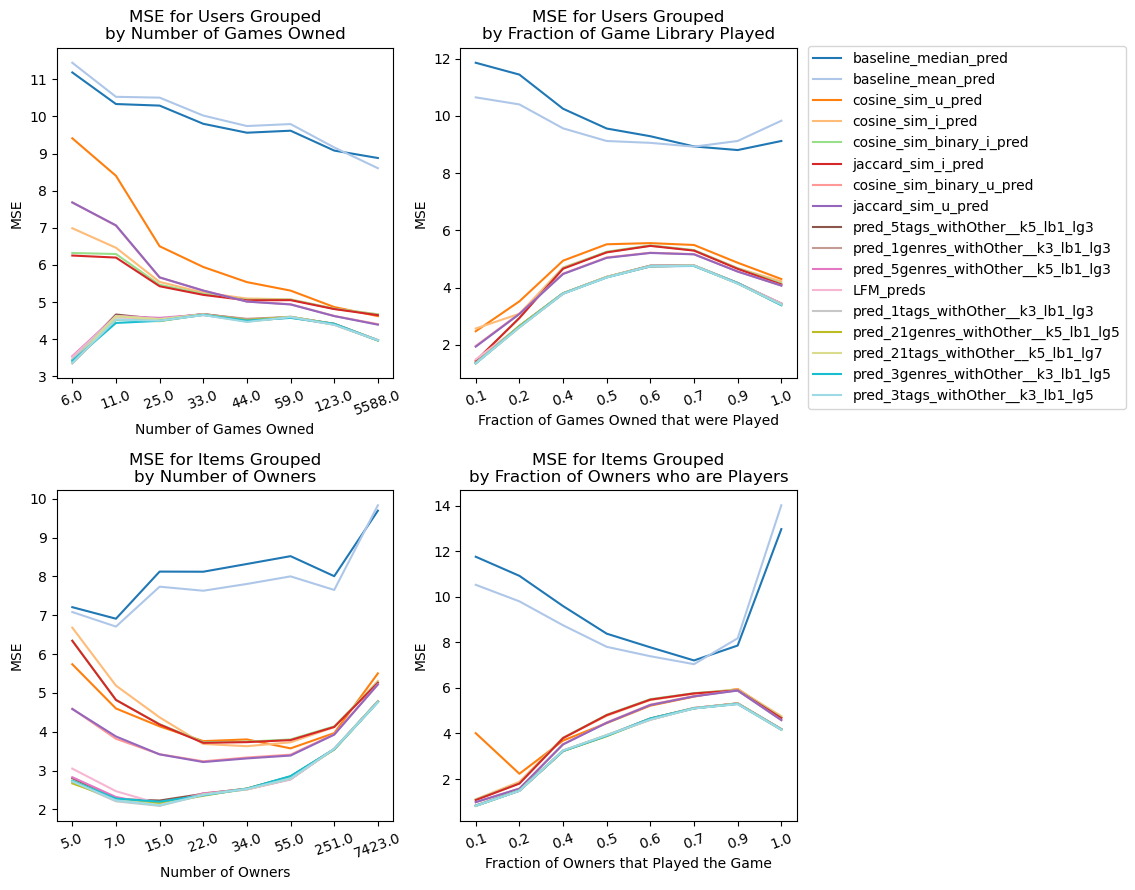

In [23]:
### MSE and MAE Across Models and Number of Games Owned Per User
grouping1 = "user"
grouping2 = "item"
###
col_types = ["count_bin", "fracPlayed_bin"]
dfs = [user_mse_dfs[(grouping1, col_type)] for col_type in col_types] + [item_mse_dfs[(grouping2, col_type)] for col_type in col_types]
titles = ["MSE for Users Grouped\nby Number of Games Owned", 
          "MSE for Users Grouped\nby Fraction of Game Library Played", 
          "MSE for Items Grouped\nby Number of Owners", 
          "MSE for Items Grouped\nby Fraction of Owners who are Players"]
xlabels = ["Number of Games Owned",
           "Fraction of Games Owned that were Played",
           "Number of Owners",
           "Fraction of Owners that Played the Game"
          ]

fig,axes = plt.subplots(2,2, figsize=(12.5,9))

for i,(df,ax,title,xlab) in enumerate(zip(dfs, axes.flatten(), titles, xlabels)):
    if i==1:
        plot_df = df.T.plot(ax=ax, cmap="tab20", legend=True)
    else:
        df.T.plot(ax=ax, cmap="tab20", legend=False)
    ###
    ax.xaxis.set_tick_params(rotation=20)
    ax.set(ylabel="MSE", xlabel=xlab, title=title)
    
plot_df.legend(loc="upper right", bbox_to_anchor=(2,1.025))
plt.tight_layout()
plt.savefig("images/results_allData", bbox_inches='tight')

plt.show()

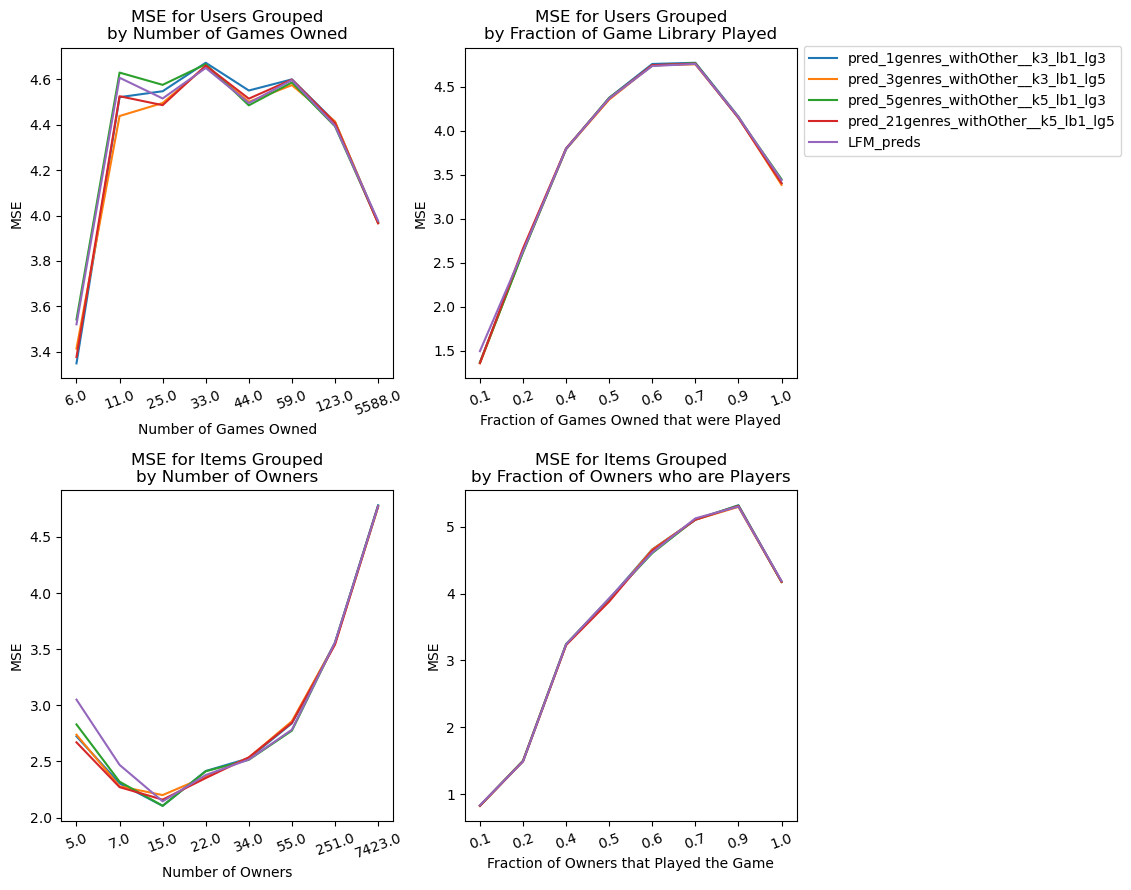

In [25]:
### MSE and MAE Across Models and Number of Games Owned Per User
grouping1 = "user"
grouping2 = "item"
keep_cols = ["pred_1genres_withOther__k3_lb1_lg3",
            "pred_3genres_withOther__k3_lb1_lg5",
            "pred_5genres_withOther__k5_lb1_lg3",
            "pred_21genres_withOther__k5_lb1_lg5",
            "LFM_preds"]
###
col_types = ["count_bin", "fracPlayed_bin"]
dfs = [user_mse_dfs[(grouping1, col_type)].loc[keep_cols] for col_type in col_types] + \
      [item_mse_dfs[(grouping2, col_type)].loc[keep_cols] for col_type in col_types]
titles = ["MSE for Users Grouped\nby Number of Games Owned", 
          "MSE for Users Grouped\nby Fraction of Game Library Played", 
          "MSE for Items Grouped\nby Number of Owners", 
          "MSE for Items Grouped\nby Fraction of Owners who are Players"]
xlabels = ["Number of Games Owned",
           "Fraction of Games Owned that were Played",
           "Number of Owners",
           "Fraction of Owners that Played the Game"
          ]

fig,axes = plt.subplots(2,2, figsize=(12.5,9))

for i,(df,ax,title,xlab) in enumerate(zip(dfs, axes.flatten(), titles, xlabels)):
    if i==1:
        plot_df = df.T.plot(ax=ax, legend=True)
    else:
        df.T.plot(ax=ax, legend=False)
    ###
    ax.xaxis.set_tick_params(rotation=20)
    ax.set(ylabel="MSE", xlabel=xlab, title=title)
    
plot_df.legend(loc="upper right", bbox_to_anchor=(2,1.025))
plt.tight_layout()
plt.savefig("images/results_genresVsLFM", bbox_inches='tight')

plt.show()

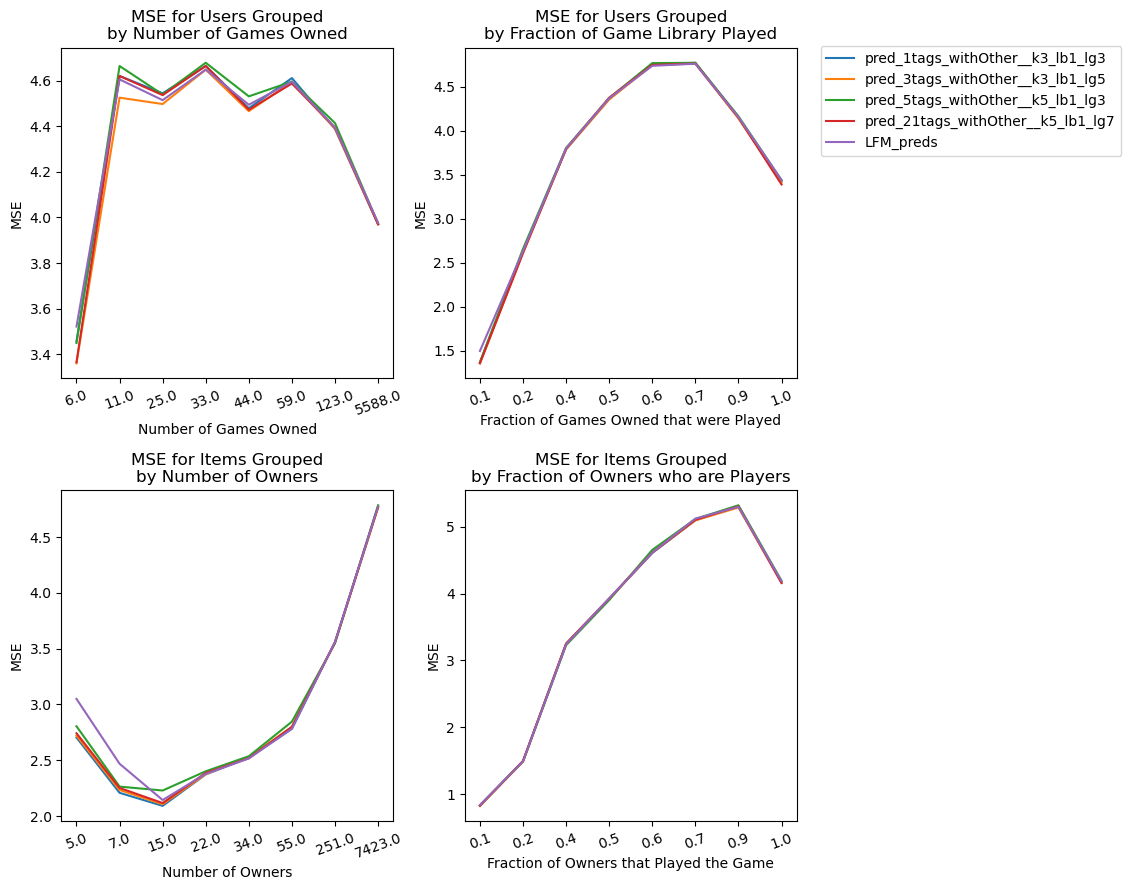

In [26]:
### MSE and MAE Across Models and Number of Games Owned Per User
grouping1 = "user"
grouping2 = "item"
keep_cols = ["pred_1tags_withOther__k3_lb1_lg3",
            "pred_3tags_withOther__k3_lb1_lg5",
            "pred_5tags_withOther__k5_lb1_lg3",
            "pred_21tags_withOther__k5_lb1_lg7",
            "LFM_preds"]
###
col_types = ["count_bin", "fracPlayed_bin"]
dfs = [user_mse_dfs[(grouping1, col_type)].loc[keep_cols] for col_type in col_types] + \
      [item_mse_dfs[(grouping2, col_type)].loc[keep_cols] for col_type in col_types]
titles = ["MSE for Users Grouped\nby Number of Games Owned", 
          "MSE for Users Grouped\nby Fraction of Game Library Played", 
          "MSE for Items Grouped\nby Number of Owners", 
          "MSE for Items Grouped\nby Fraction of Owners who are Players"]
xlabels = ["Number of Games Owned",
           "Fraction of Games Owned that were Played",
           "Number of Owners",
           "Fraction of Owners that Played the Game"
          ]

fig,axes = plt.subplots(2,2, figsize=(12.5,9))

for i,(df,ax,title,xlab) in enumerate(zip(dfs, axes.flatten(), titles, xlabels)):
    if i==1:
        plot_df = df.T.plot(ax=ax, legend=True)
    else:
        df.T.plot(ax=ax, legend=False)
    ###
    ax.xaxis.set_tick_params(rotation=20)
    ax.set(ylabel="MSE", xlabel=xlab, title=title)
    
plot_df.legend(loc="upper right", bbox_to_anchor=(2,1.025))
plt.tight_layout()
plt.savefig("images/results_tagsVsLFM", bbox_inches='tight')

plt.show()

In [ ]:
# ### MSE and MAE Across Models and Number of Games Owned Per User
# grouping1 = "user"
# grouping2 = "item"
# keep_cols = ["pred_21tags_withOther__k5_lb1_lg7",
#             "pred_3genres_withOther__k3_lb1_lg5",
#             "LFM_preds"]
# ###
# col_types = ["count_bin", "fracPlayed_bin"]
# dfs = [user_mse_dfs[(grouping1, col_type)].loc[keep_cols] for col_type in col_types] + \
#       [item_mse_dfs[(grouping2, col_type)].loc[keep_cols] for col_type in col_types]
# titles = ["MSE for Users Grouped\nby Number of Games Owned", 
#           "MSE for Users Grouped\nby Fraction of Game Library Played", 
#           "MSE for Items Grouped\nby Number of Owners", 
#           "MSE for Items Grouped\nby Fraction of Owners who are Players"]
# xlabels = ["Number of Games Owned",
#            "Fraction of Games Owned that were Played",
#            "Number of Owners",
#            "Fraction of Owners that Played the Game"
#           ]

# fig,axes = plt.subplots(2,2, figsize=(12.5,9))

# for i,(df,ax,title,xlab) in enumerate(zip(dfs, axes.flatten(), titles, xlabels)):
#     if i==1:
#         plot_df = df.T.plot(ax=ax, legend=True)
#     else:
#         df.T.plot(ax=ax, legend=False)
#     ###
#     ax.xaxis.set_tick_params(rotation=20)
#     ax.set(ylabel="MSE", xlabel=xlab, title=title)
    
# plot_df.legend(loc="upper right", bbox_to_anchor=(2,1.025))
# plt.tight_layout()
# plt.savefig("images/results_top3", bbox_inches='tight')

# plt.show()